In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import preprocessing as pp
%reload_ext autoreload

def horizontal_projection(image):
  """
  Calculates the horizontal projection profile of a binary image.

  Args:
      image: A binary image (grayscale image with 0 for background and 255 for foreground).

  Returns:
      A list representing the horizontal projection profile (number of foreground pixels in each row).
  """
  projection = np.count_nonzero(image == 255, axis=1)
  return projection.tolist()

def find_peak_values(projection, min_peak_height=15):
  """
  Finds peak values (local maxima) in a 1D list representing a projection profile.

  Args:
      projection: A list representing the horizontal projection profile.
      min_peak_height: Minimum height threshold for considering a peak (optional).

  Returns:
      A list of peak value indices in the projection profile.
  """
  peaks = []
  for i in range(1, len(projection)-1):
    if projection[i] > projection[i-1] and projection[i] > projection[i+1] and projection[i] >= min_peak_height:
      peaks.append(i)
  return peaks
  
  # peaks = []
  # for i in range(1, len(projection)-1):
  #   if projection[i] > projection[i-1] and projection[i] > projection[i+1] and projection[i] >= min_peak_height:
  #     peaks.append(i)
  # return peaks



def detect_baselines(image):
  """
  Detects multiple baseline indices in a binary line image using horizontal projection.

  Args:
      image: A binary image representing a line of text.

  Returns:
      A list of baseline indices (row indices) in the image and the projection profile.
  """
  # Otsu's thresholding
  image = pp.otsu_thresholding(image)
  # Optional thinning (uncomment if needed)
  thinned_image = cv2.ximgproc.thinning(image.copy())
  # Horizontal projection
  projection = horizontal_projection(thinned_image)
  # Optional smoothing (uncomment if needed)
  smoothed_projection = savgol_filter(projection, 5, 1)

  # Find peak values (potential baseline locations)
  peaks = find_peak_values(smoothed_projection)

  baseline_index = 0
  max = 0
  peak = []
  for i in range(len(peaks)):
    if (smoothed_projection[peaks[i]] > max):
      baseline_index = peaks[i]
      max = smoothed_projection[peaks[i]]

  # Consider potential filtering/merging of close peaks (optional)
  peak.append(baseline_index)
  return peak, smoothed_projection

def draw_baselines(image, baseline_indices):
  """
  Draws multiple baselines on the input image.

  Args:
      image: The binary image.
      baseline_indices: A list of row indices for the detected baselines.

  Returns:
      The image with all baselines drawn.
  """
  image_copy = image.copy()
  colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]  # Define different colors for multiple baselines (optional)
  for i, baseline_index in enumerate(baseline_indices):
    cv2.line(image_copy, (0, baseline_index), (image.shape[1], baseline_index), colors[i % len(colors)])  # Draw lines with color cycling
  return image_copy


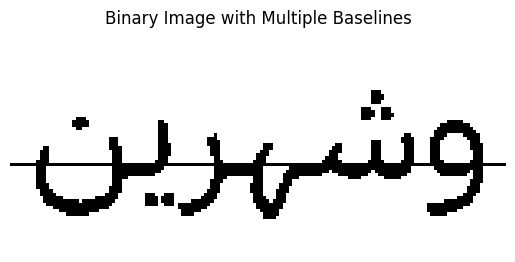

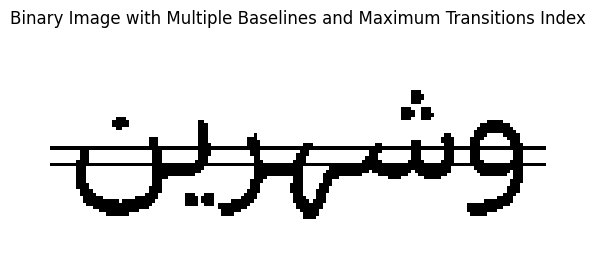

baseline_indices: [40]
max_transitions_index: 35


In [14]:
def find_max_transitions(image, baseline_index):
    # Otsu's thresholding if needed
    image = pp.otsu_thresholding(image)
    max_transitions = 0
    max_transitions_index = baseline_index    
    
    i = baseline_index
    while i >= 0:
        current_transitions = 0
        flag = False  # Flag to track if we are counting transitions
        width = len(image[0])        
        j = width - 1
        while j >= 0:
            if image[i][j] == 255 and not flag:
                current_transitions += 1
                flag = True
            elif image[i][j] != 255 and flag:
                flag = False
            j -= 1
            
        if current_transitions >= max_transitions:
            max_transitions = current_transitions
            max_transitions_index = i
        i -= 1

    return max_transitions_index

def draw_max_transitions(image, max_transitions_index):
    image_copy = image.copy()
    cv2.line(image_copy, (0, max_transitions_index), (image.shape[1], max_transitions_index), (0, 0, 255))
    return image_copy



# Example usage (replace 'path/to/your/image.png' with your actual image path)
line_image = cv2.imread('IBM-1-word.jpg', cv2.IMREAD_GRAYSCALE)
thresh, binary_image = cv2.threshold(line_image, 127, 255, cv2.THRESH_BINARY)  # Binarize image

# Detect multiple baselines
baseline_indices, projection = detect_baselines(binary_image)
# Draw baselines on image
image_with_baselines = draw_baselines(binary_image, baseline_indices)
# Detect maximum transitions index
max_transitions_index = find_max_transitions(binary_image, baseline_indices[0])
# Draw maximum transitions index on image
image_with_max_transitions = image_with_baselines.copy()
image_with_max_transitions = draw_max_transitions(image_with_max_transitions, max_transitions_index)

# Display the image with multiple baselines (consider using subplots for projection)
plt.imshow(image_with_baselines, cmap='gray')
plt.title('Binary Image with Multiple Baselines')
plt.axis('off')
plt.show()

# Display the image with multiple baselines and maximum transitions index
plt.imshow(image_with_max_transitions, cmap='gray')
plt.title('Binary Image with Multiple Baselines and Maximum Transitions Index')
plt.axis('off')
plt.show()

print("baseline_indices:", baseline_indices)
print("max_transitions_index:", max_transitions_index)



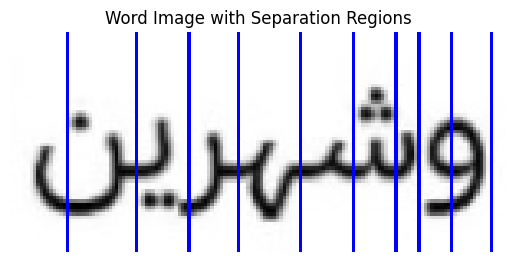

cut_points: [SeparationRegion(StartIndex=143, EndIndex=150, CutIndex=146), SeparationRegion(StartIndex=130, EndIndex=139, CutIndex=134), SeparationRegion(StartIndex=122, EndIndex=127, CutIndex=124), SeparationRegion(StartIndex=112, EndIndex=119, CutIndex=117), SeparationRegion(StartIndex=100, EndIndex=109, CutIndex=104), SeparationRegion(StartIndex=79, EndIndex=97, CutIndex=88), SeparationRegion(StartIndex=63, EndIndex=76, CutIndex=69), SeparationRegion(StartIndex=48, EndIndex=60, CutIndex=54), SeparationRegion(StartIndex=33, EndIndex=44, CutIndex=38), SeparationRegion(StartIndex=11, EndIndex=29, CutIndex=17)]


In [16]:
import numpy as np
import cv2
from scipy import stats
import collections

# Function to perform morphological opening with a 2x2 structuring element
def morphological_open(line_image):
    kernel = np.ones((2, 2), np.uint8)
    opened_image = cv2.morphologyEx(line_image, cv2.MORPH_OPEN, kernel)
    return opened_image

# Function to compute the vertical projection of a binary image
def vertical_projection(line_image):
    return np.count_nonzero(line_image == 255, axis=0).tolist()  # Assuming white is foreground (255)

# Function to get the most frequent value (mode) from the vertical projection
def mode(values):
    mode_value = stats.mode(values).mode
    return mode_value

# Data structure for separation regions
SeparationRegion = collections.namedtuple("SeparationRegion", ["StartIndex", "EndIndex", "CutIndex"])

# Cut point identification algorithm implementation
def identify_cut_points(line_image, word_image, mti):
    # Otsu thresholding if needed
    line_image = pp.otsu_thresholding(line_image)
    word_image = pp.otsu_thresholding(word_image)

    # Step 1: Perform morphological opening on the line image
    line_image = morphological_open(line_image)

    # Step 2: Compute the vertical projection
    vertical_proj = vertical_projection(line_image)

    # Step 3: Compute the mode of the vertical projection
    mfv = mode(vertical_proj)

    # Step 4: Iterate through the width of the word image to find separation regions
    separation_regions = []
    flag = False
    sr = None
    width = word_image.shape[1]
    for i in range(width - 1, -1, -1):  # Start from 1 to avoid boundary issues
        if (word_image[mti, i] == 0) and not flag:  # White to black transition
            sr = SeparationRegion(StartIndex=None, EndIndex=i, CutIndex=None)
            flag = True
        elif (word_image[mti, i] != 0) and flag:  # Black to white transition
            sr = sr._replace(StartIndex=i)
            mid_index = (sr.EndIndex + sr.StartIndex) // 2
            
            # Determine cut index
            if np.any(vertical_proj[sr.StartIndex:sr.EndIndex] == 0):  # Non-overlapping
                cut_index = mid_index  # Default cut index

                # Find nearest point to mid_index where VP is zero
                zero_points = np.where(vertical_proj[sr.StartIndex:sr.EndIndex] == 0)[0]
                if len(zero_points) > 0:
                    cut_index = sr.StartIndex + zero_points[np.argmin(abs(zero_points - (mid_index - sr.StartIndex)))]

            elif vertical_proj[mid_index] == mfv:  # Check baseline thickness
                cut_index = mid_index
            else:
                # Check for points with vertical projection <= MFV to find cut index
                mfv_points = np.where((vertical_proj[sr.StartIndex:sr.EndIndex] <= mfv))[0]
                if len(mfv_points) > 0:
                    cut_index = sr.StartIndex + mfv_points[np.argmin(abs(mfv_points - (mid_index - sr.StartIndex)))]
                else:
                    cut_index = mid_index  # Fallback to midpoint if no MFV points are found

            # Update the separation region with the cut index
            sr = sr._replace(CutIndex=cut_index)
            separation_regions.append(sr)
            flag = False

    return separation_regions

# Function to draw separation regions on the word image
def draw_separation_regions(word_image, separation_regions):
    word_image_copy = cv2.cvtColor(word_image, cv2.COLOR_GRAY2BGR)
    for sr in separation_regions:
        cv2.line(word_image_copy, (sr.CutIndex, 0), (sr.CutIndex, word_image.shape[0]), (0, 0, 255), 1)
    return word_image_copy

# Example usage
# Load the word image
word_image = cv2.imread('IBM-1-word.jpg', cv2.IMREAD_GRAYSCALE)
thresh, binary_word_image = cv2.threshold(word_image, 127, 255, cv2.THRESH_BINARY)  # Binarize image

# Identify cut points
cut_points = identify_cut_points(binary_image, binary_word_image, max_transitions_index)
# Draw separation regions on the word image
word_image_with_separation_regions = draw_separation_regions(word_image, cut_points)

# Display the word image with separation regions
plt.imshow(word_image_with_separation_regions, cmap='gray')
plt.title('Word Image with Separation Regions')
plt.axis('off')
plt.show()

print("cut_points:", cut_points)


(1181, 1181)
1181
[   0 1181]
227.56843999168117 229.62967593124793
107.53233977628885 109.59357571585562
272.5819775724531 274.64321351201994
347.6045402070732 349.66577614664004
312.59401097758393 314.6552469171507
147.54437318141962 149.6056091209864
187.5564065865504 189.61764252611718
392.61807778784544 394.67931372741225
90.5272255791082 92.58846151867499
326.5982226693797 328.65945860894647
247.57445669424644 249.63569263381322


Text(0.5, 1.0, 'Detected lines')

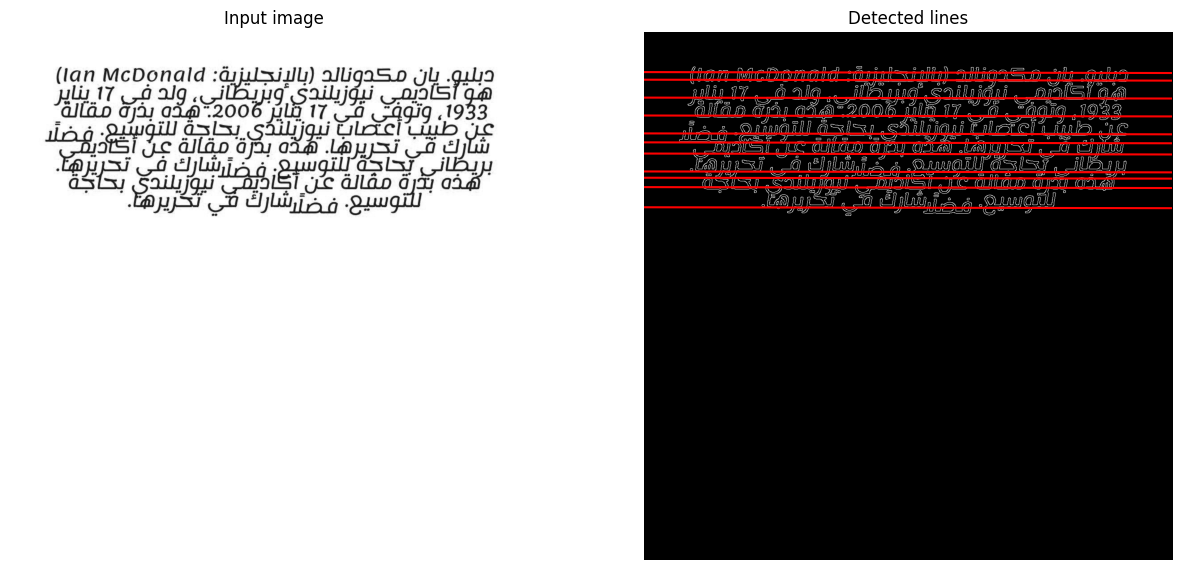

In [3]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode

image = rgb2gray(imread("fonts-dataset/Lemonada/900.jpeg"))

edges = canny(image)
# Classic straight-line Hough transform
tested_angles = np.deg2rad(np.arange(0.1, 180.0))
h, theta, d = hough_line(edges, theta=tested_angles)

print(image.shape)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

print(image.shape[1])
print(origin)

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
    print(y0, y1)
    
ax[1].set_xlim(origin)
ax[1].set_ylim((edges.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')




In [4]:
import cv2
import os

# Define folder path
folder_path = "fonts-dataset/Lemonada"

# Loop through images in the folder
for filename in os.listdir(folder_path):
  # Check if it's an image file
  if filename.lower().endswith((".jpg", ".jpeg", ".png")):
    # Read the image
    img = cv2.imread(os.path.join(folder_path, filename))
    
    # Check if image read successfully
    if img is not None:
      # Get image shape (height, width) - OpenCV uses (H, W) order
      height, width, channels = img.shape
      # Print the shape
      print(f"{filename}: {width} x {height} (channels: {channels})")



0.jpeg: 1181 x 1181 (channels: 3)
1.jpeg: 1181 x 1181 (channels: 3)
10.jpeg: 1181 x 1181 (channels: 3)
100.jpeg: 1181 x 1181 (channels: 3)
101.jpeg: 1181 x 1181 (channels: 3)
102.jpeg: 1181 x 1181 (channels: 3)
103.jpeg: 1181 x 1181 (channels: 3)
104.jpeg: 1181 x 1181 (channels: 3)
105.jpeg: 1181 x 1181 (channels: 3)
106.jpeg: 1181 x 1181 (channels: 3)
107.jpeg: 1181 x 1181 (channels: 3)
108.jpeg: 1181 x 1181 (channels: 3)
109.jpeg: 1181 x 1181 (channels: 3)
11.jpeg: 1181 x 1181 (channels: 3)
110.jpeg: 1181 x 1181 (channels: 3)
111.jpeg: 1181 x 1181 (channels: 3)
112.jpeg: 1181 x 1181 (channels: 3)
113.jpeg: 1181 x 1181 (channels: 3)
114.jpeg: 1181 x 1181 (channels: 3)
115.jpeg: 1181 x 1181 (channels: 3)
116.jpeg: 1181 x 1181 (channels: 3)
117.jpeg: 1181 x 1181 (channels: 3)
118.jpeg: 1181 x 1181 (channels: 3)
119.jpeg: 1181 x 1181 (channels: 3)
12.jpeg: 1181 x 1181 (channels: 3)
120.jpeg: 1181 x 1181 (channels: 3)
121.jpeg: 1181 x 1181 (channels: 3)
122.jpeg: 1181 x 1181 (channels: 3)